In [48]:
import os
import torch as tr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba
from sklearn.metrics.pairwise import cosine_similarity


WM Model

In [49]:
# Train WM model 

class FFWM(tr.nn.Module):
  """ Model used for Sternberg and N-back """
  def __init__(self,indim,hiddim,outdim=2,bias=False,add_noise=False):
    super().__init__()
    self.indim = indim
    self.hiddim = hiddim
    self.add_noise = add_noise
    self.hid1_layer = tr.nn.Linear(indim,indim,bias=bias)
    self.hid2_layer = tr.nn.Linear(indim,hiddim,bias=bias)
    self.out_layer = tr.nn.Linear(hiddim,outdim,bias=bias)
    self.drop2 = tr.nn.Dropout(p=0.05, inplace=False)
    bias_dim = indim
    max_num_bias_modes = 10
    self.embed_bias = tr.nn.Embedding(max_num_bias_modes,bias_dim)
    return None

  def forward(self,inputL,control_bias_int=0):
    """ inputL is list of tensors """
    hid1_in = tr.cat(inputL,-1)
    hid1_act = self.hid1_layer(hid1_in).relu()
    control_bias = self.embed_bias(tr.tensor(control_bias_int))
    hid2_in = hid1_act + control_bias
    if self.add_noise:
      hid2_in = hid2_in + (0.1 ** 0.5) * tr.randn(hid2_in.shape)
    hid2_in = self.drop2(hid2_in)
    hid2_act = self.hid2_layer(hid2_in).relu()
    yhat_t = self.out_layer(hid2_act)
    return yhat_t


def run_model_for_epochs(net, taskL, ctxt_fn, stim_fn, training, neps_per_task, n_ctxt_steps, verb=True):
  if training:
    net.train()
    print("Training WM...")
  else:
    net.eval()
    print("Evaluating WM...")
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  score = -np.ones([len(taskL), neps_per_task])
  ttype = -np.ones([len(taskL), neps_per_task])
  for ep in range(neps_per_task):
    if verb and ep % (neps_per_task / 5) == 0:
      print(ep / neps_per_task)
    # resample stim and context on each ep
    stimset = tr.Tensor(stim_fn())
    cdrift = ctxt_fn(n_steps=n_ctxt_steps)
    cdrift = tr.Tensor(cdrift)
    # interleave train on every task per epoch
    for task_idx,(control_int,sample_trial_fn,setsize) in enumerate(taskL): 
      # use the input function to generate a trial sample
      out = sample_trial_fn(stimset,cdrift,setsize)
      stim_t,stim_m,context_t,context_m,ytarget, ttype_idx = out
      # forward prop
      inputL = [stim_t,stim_m,context_t,context_m]
      yhat = net(inputL,control_bias_int=control_int)
      # eval
      score[task_idx, ep] = maxsoftmax(yhat)==ytarget
      ttype[task_idx, ep] = ttype_idx
      # backprop
      if training:
        eploss = lossop(yhat.unsqueeze(0), ytarget)
        optiop.zero_grad()
        eploss.backward(retain_graph=True)
        optiop.step()
  return score, ttype

maxsoftmax = lambda x: tr.argmax(tr.softmax(x,-1),-1).squeeze()


Context Model

In [50]:
# model of CR as spherical coordinates updated by a noisy drift
def spherical_drift(n_steps=20, dim=10, var=0.25, mean=0.25):
    # initialize the spherical coordinates to ensure each context run begins in a new random location on the unit sphere
    ros = np.random.random(dim - 1)
    slen = n_steps
    ctxt = np.zeros((slen, dim))
    for i in range(slen):
        noise = np.random.normal(mean, var, size=(dim - 1)) # add a separately-drawn Gaussian to each spherical coord
        ros += noise
        ctxt[i] = convert_spherical_to_angular(dim, ros)
    return ctxt

# Convert spherical coordinates to angular ones
def convert_spherical_to_angular(dim, ros):
    ct = np.zeros(dim)
    ct[0] = np.cos(ros[0])
    prod = np.product([np.sin(ros[k]) for k in range(1, dim - 1)])
    n_prod = prod
    for j in range(dim - 2):
        n_prod /= np.sin(ros[j + 1])
        amt = n_prod * np.cos(ros[j + 1])
        ct[j + 1] = amt
    ct[dim - 1] = prod
    return ct
    
    
# Generate identity matrix where each row is a one-hot representation of a stimulus
def gen_stims(sdim):
    return np.identity(sdim)

NBack and Sternberg Tasks

In [51]:
def single_sternberg_comparison(stimset,cdrift,setsize,
  pr_match,pr_stim_lure,pr_context_lure):
  # task params
  stimset_size,sdim = stimset.shape

  # set current stim and context
  stim_t_idx = np.random.randint(stimset_size)
  stim_t = stimset[stim_t_idx,:]
  context_t_idx = setsize * 2 + 1 # the current trace is always the test probe from the second list
  context_t = cdrift[context_t_idx]

  ## define positive and negative samples
  stim_pos = stim_t
  context_pos_idx = context_t_idx - np.random.randint(0, setsize)
  context_pos = cdrift[context_pos_idx]
  # negative context, different trial
  context_neg_idx = context_t_idx - np.random.randint(setsize + 1, setsize * 2 + 1)
  context_neg = cdrift[context_neg_idx]
  # stim
  stim_neg_idx = np.random.choice(np.setdiff1d(range(stimset_size), stim_t_idx))
  stim_neg = stimset[stim_neg_idx]

  # trial type
  ttype_randn = np.random.random()

  # both match
  if ttype_randn<pr_match:
    # positive trial
    stim_m  = stim_pos
    context_m  = context_pos
    ytarget = tr.LongTensor([1])
    ttype_idx = 0
  # slure: stim match (context no match)
  elif ttype_randn<pr_match+pr_stim_lure:
    # stim lure
    stim_m = stim_pos
    context_m = context_neg
    ytarget = tr.LongTensor([0])
    ttype_idx = 2
  # clure: context match (stim no match)
  elif ttype_randn<pr_match+pr_stim_lure+pr_context_lure:
    # context lure
    stim_m = stim_neg
    context_m = context_pos
    ytarget = tr.LongTensor([0])
    ttype_idx = 1
  # neither match
  else:
    # negative trial
    stim_m = stim_neg
    context_m = context_neg
    ytarget = tr.LongTensor([0])
    ttype_idx = 3
  return stim_t,context_t,stim_m,context_m,ytarget,ttype_idx

def single_nback_comparison(stimset,cdrift,setsize,
  pr_match,pr_stim_lure,pr_context_lure):
  """ 
  Returns a pair of a stimulus-context traces representing a currently-active stimulus and context & a single trace
  retrieved from memory. Generates this pair based on the four comparison types laid out in the paper:
    both-match, stim lure, context lure, neither match.
  output is a 4-tuple (s_t,c_t,s_r,c_r), as well as ytarget and ttype_code which encodes the trial type for error reporting.
  """
  ntokens,sdim = stimset.shape
  min_context_t = setsize

  # set current stim and context
  stim_t_idx = np.random.randint(0,ntokens)
  context_t_idx = np.random.randint(min_context_t, ntokens)
  stim_t = stimset[stim_t_idx]
  context_t = cdrift[context_t_idx]

  ttype_randn = np.random.random()  # randomly-selected trial type
  ttype_code = -1 # code used to record trial type for analysis

  if ttype_randn < pr_match:
    stim_m, context_m = nback_both_match(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
    ytarget = tr.LongTensor([1])
    ttype_code = 0

  elif ttype_randn < (pr_match + pr_context_lure):
    stim_m, context_m = nback_ctxt_lure(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
    ytarget = tr.LongTensor([0])
    ttype_code = 1

  elif ttype_randn < (pr_match + pr_context_lure + pr_stim_lure):
    stim_m, context_m = nback_stim_lure(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
    ytarget = tr.LongTensor([0])
    ttype_code = 2

  else:
    stim_m, context_m = nback_neither_match(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
    ytarget = tr.LongTensor([0])
    ttype_code = 3

  return stim_t,stim_m,context_t,context_m,ytarget, ttype_code


# return a both match trace -- the stimuli match, and the context is the n-back context
def nback_both_match(stim_set, cdrift, stim_t_idx, context_t_idx, setsize, ntokens):
    stim_m = stim_set[stim_t_idx]
    context_m = cdrift[context_t_idx - setsize]
    return (stim_m, context_m)

# return a stim lure trace -- the stimuli match, but the context is not the n-back context
def nback_stim_lure(stim_set, cdrift, stim_t_idx, context_t_idx, setsize, ntokens):
    stim_m = stim_set[stim_t_idx]
    context_m = get_lure_context(cdrift, context_t_idx, ntokens, setsize)
    return (stim_m, context_m)

# return a context lure trace -- the stimuli don't match, but the context is the n-back context
def nback_ctxt_lure(stim_set, cdrift, stim_t_idx, context_t_idx, setsize, ntokens):
    idx_stim_m = np.random.choice(np.setdiff1d(range(ntokens), stim_t_idx))
    stim_m = stim_set[idx_stim_m]
    context_m = cdrift[context_t_idx - setsize]
    return (stim_m, context_m)

# return a neither match trace -- the stimuli don't match, and the context is not the n-back context.
# optionally, for the EM simulations, this can probabilistically return a matching stimulus and a long-past context
# (s.t. the trace isn't a proper lure, but simulates the repeating-stimuli dynamics of the task).
def nback_neither_match(stim_set, cdrift, stim_t_idx, context_t_idx, setsize, ntokens, pr_prewindow_match = 0.0):
    if np.random.uniform() > pr_prewindow_match or ntokens - context_t_idx < 6:
        idx_stim_m = np.random.choice(np.setdiff1d(range(ntokens), stim_t_idx))
        stim_m = stim_set[idx_stim_m]
        context_m = get_lure_context(cdrift, context_t_idx, ntokens, setsize)
        return stim_m, context_m
    else:
        return nback_distant_slure(stim_set, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)

# A trial type where the stimulus DOES match, but the context is so far from the target context that it isn't a lure
def nback_distant_slure(stim_set, cdrift, stim_t_idx, context_t_idx, setsize, ntokens):
    idx_stim_m = np.random.choice(np.setdiff1d(range(ntokens), stim_t_idx))
    nback_context_idx = context_t_idx + setsize
    rlo = max(0, nback_context_idx - 6)
    rhi = min(nback_context_idx - 2, ntokens)
    idx_context_m = np.random.choice(range(rlo, rhi))
    stim_m = stim_set[idx_stim_m]
    context_m = cdrift[idx_context_m]
    return stim_m, context_m

def get_lure_context(cdrift, context_t_idx, ntokens, setsize):
    try:
        nback_context_idx = context_t_idx - setsize
        rlo = max(0, nback_context_idx - 2)
        rhi = min(nback_context_idx + setsize, ntokens)
        idx_context_m = np.random.choice(np.setdiff1d(range(rlo, rhi), nback_context_idx))
        context_m = cdrift[idx_context_m]
        return context_m
    except:
        print("Error in generating lure context")
        return

Generate WM figures

In [52]:
# plot training accuracy
def plot_train_accuracy(score_tr,
                        ttype,
                        ssizeL,
                        figure_path=""):

  task_labels = ["setsize " + str(ssize) for ssize in ssizeL]
  colors = [["#edc174", "#d4982f", "#c27e08", "#a1690a"], ["#8dcbf7", "#61b3ed", "#2a86c7", "#0762a3"]]
  labels = ["match", "slure", "clure", "nomatch"]
  n_intervals = 1000
  for i in range(len(score_tr)):
    task_score = score_tr[i]
    task_color = colors[i]
    task_trialtypes = ttype[i]
    for tt in range(4):
      filt_inds = task_trialtypes == tt
      ep_ttype = np.extract(filt_inds, task_score)
      ep_ttype = ep_ttype[:-(len(ep_ttype)%n_intervals)]
      ac = ep_ttype.reshape(-1, n_intervals).mean(1)
      lt = task_labels[i] + " " + labels[tt]
      plt.plot(ac, color=task_color[tt], label=lt)
  plt.legend(loc="best")
  plt.ylim(0, 1)
  plt.ylabel('Train accuracy')
  if not load_pretrained_WM: 
    plt.savefig(figure_path + "/train-accuracy")
    plt.close('all')

def eval_by_ttype(net, ctxt_fn, stim_fn, sample_fn, taskintL, ssizeL, n_ctxt_steps, neps):
  """ eval on given task for separate trial types
  returns evac on (match,nomatch,slure,clure)
  """

  taskL_ev = []
  # generate a list of tasks which are trials all of one kind so we can see accuracy by trial type
  for task_int in taskintL:
    taskL_ev.append([task_int, sample_fn(1, 0, 0), ssizeL[task_int]])
    taskL_ev.append([task_int, sample_fn(0, 0, 0), ssizeL[task_int]])
    taskL_ev.append([task_int, sample_fn(0, 1, 0), ssizeL[task_int]])
    taskL_ev.append([task_int, sample_fn(0, 0, 1), ssizeL[task_int]])

  evsc, ttype = run_model_for_epochs(
    net, 
    taskL_ev,
    ctxt_fn=ctxt_fn,
    stim_fn = stim_fn,
    training=False,
    neps_per_task=neps,
    n_ctxt_steps=n_ctxt_steps,
    verb=False
  )

  evac = evsc.mean(1)
  print(evac)
  # regroup the list of scores into a list of lists grouped by the setsize
  scores_by_ss = [[]] * len(taskintL)
  for task_int in taskintL:
    scores_by_ss[task_int] = evac[task_int*4:(task_int+1)*4]
  return scores_by_ss

# eval on neps_ev iterations of each trial type and plot the accuracy for each
def plot_accuracy_by_trial_type(evac,
                                taskintL,
                                ssizeL,
                                figure_path=""):
  for tidx, (task_int, ssize) in enumerate(zip(taskintL, ssizeL)):
    plt.title('Accuracy by trial type')
    plt.bar(np.arange(4) + (.45 * tidx), evac[tidx], width=.45, label="setsize:" + str(ssize))
  plt.legend()
  plt.xticks(range(4), ['match', 'nomatch', 'slure', 'clure'])
  if not load_pretrained_WM:
    plt.savefig(figure_path + "/trial-type-accuracy")
    plt.close('all')

In [53]:
def train_net_and_plot_accuracy(task, ctxt_fn, stim_fn, c_dim, s_dim, neps, n_ctxt_steps, pr_match, pr_slure, pr_clure, seed, model_path, figure_path):
  np.random.seed(seed)
  tr.random.manual_seed(seed)

  ## net params
  indim = 2 * (c_dim + s_dim)
  hiddim = s_dim * 4

  if task == 'nback':
    ssizeL = [2, 3] # [1, 3]
    sample_fn = lambda match,slure,clure: lambda S,C,N: single_nback_comparison(S,C,N,
                  pr_match=match,pr_stim_lure=slure,pr_context_lure=clure
                  )
  elif task == 'stern':
    ssizeL = [4,9]
    sample_fn = lambda match,slure,clure: lambda S,C,N: single_sternberg_comparison(S,C,N,
                  pr_match=match,pr_stim_lure=slure,pr_context_lure=clure
                  )

  taskintL = [0,1]
  taskL_tr = [
    [taskintL[0],sample_fn(pr_match,pr_slure,pr_clure),ssizeL[0]],
    [taskintL[1],sample_fn(pr_match,pr_slure,pr_clure),ssizeL[1]],
  ]

  # init net
  net = FFWM(indim,hiddim)

  # train net
  score_tr, ttype = run_model_for_epochs(
    net,
    taskL_tr,
    ctxt_fn=ctxt_fn,
    stim_fn = stim_fn,
    training=True,
    neps_per_task=neps,
    n_ctxt_steps=n_ctxt_steps)

  np.save(model_path + "/train-score", score_tr)
  tr.save(net.state_dict(), model_path + "/trained-net.pt")

  plot_train_accuracy(score_tr, ttype, ssizeL, figure_path)

  scores_by_ttype = eval_by_ttype(net, ctxt_fn, stim_fn, sample_fn, taskintL, ssizeL, n_ctxt_steps, neps=1000)
  plot_accuracy_by_trial_type(scores_by_ttype, taskintL, ssizeL, figure_path)

  return net


def generate_ttype_figures_for_trained_model(net, task, ctxt_fn, stim_fn, n_ctxt_steps): 
  if task == 'nback':
    ssizeL = [2, 3]
    sample_fn = lambda match,slure,clure: lambda S,C,N: single_nback_comparison(S,C,N,
                  pr_match=match,pr_stim_lure=slure,pr_context_lure=clure
                  )
  elif task == 'stern':
    ssizeL = [4,9]
    sample_fn = lambda match,slure,clure: lambda S,C,N: single_sternberg_comparison(S,C,N,
                  pr_match=match,pr_stim_lure=slure,pr_context_lure=clure
                  )

  taskintL = [0,1]
    
  scores_by_ttype = eval_by_ttype(net, ctxt_fn, stim_fn, sample_fn, taskintL, ssizeL, n_ctxt_steps, neps=1000)
  plot_accuracy_by_trial_type(scores_by_ttype, taskintL, ssizeL)


Set Parameters & Actually Train / Load a WM Model

Evaluating WM...
[0.966 1.    0.881 1.    0.97  1.    0.805 0.996]


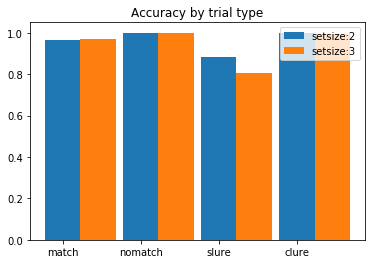

In [60]:
# change this variable to change the task between nback and stern
task = "nback"  # "stern"

# function and parameters for the drifting context
ctxt_fn_name = spherical_drift
ctxt_d = 25
n_ctxt_steps=20
drift_parameters = (0.25, 0.075) # [(0.25, 0.075), (0.25, 0.0), (0.25, 0.05), (0.4, 0.075)]
mean, var = drift_parameters
# Lambda getter for the context fn with these parameters
ctxt_fn = lambda n_steps: spherical_drift(n_steps=n_steps, dim=ctxt_d, var=var, mean=mean)

# function which returns a stimulus
stim_d = 20
stim_fn = lambda: gen_stims(stim_d) # lambda: gen_stims(stim_d)

# Flip this flag to train WM model from scratch -- recommended to download as .py file and run locally
load_pretrained_WM = True

if load_pretrained_WM: 
    ffwm_path = os.path.dirname(os.path.realpath(__file__)) + "/../trained-models/ffwm_task-nback_training-probs-040-020-020-020_neps-500000_drift-params-025-007_seed%2/trained-net.pt"
    ffwm = FFWM(2 * (ctxt_d + stim_d), stim_d * 4)
    ffwm.load_state_dict(tr.load(ffwm_path))
    ffwm.eval()
    figure_path = ""
    generate_ttype_figures_for_trained_model(ffwm, task, ctxt_fn, stim_fn, n_ctxt_steps=n_ctxt_steps)
else: 
    n_training_eps = 500000
    seed = 0
    
    # probabilities of different training conditions: both match, stimulus lure, context lure, neither match
    pr_match, pr_slure, pr_clure, pr_nomatch = 0.4, 0.2, 0.2, 0.2

    # create directories for the model and figures
    model_name = 'ffwm_task-{}_training-probs-{:.2f}-{:.2f}-{:.2f}-{:.2f}_neps-{:d}_drift-params-{:.2f}-{:.2f}_seed{:d}'.format(
        task, pr_match, pr_slure, pr_clure, pr_nomatch, n_training_eps, mean, var, seed)
    dirname = os.path.dirname(__file__)
    model_path = os.path.join(dirname, '../trained-models/' + model_name)
    figure_path = model_path
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        
    ffwm = train_net_and_plot_accuracy(task, ctxt_fn, stim_fn, c_dim=ctxt_d, s_dim=stim_d, neps=n_training_eps, n_ctxt_steps=n_ctxt_steps,
                                    pr_match=pr_match, pr_slure=pr_slure, pr_clure=pr_clure, seed=seed,
                                    model_path=model_path, figure_path=figure_path)



EM Model

In [61]:
# Calculate the cosine similarity between two vectors
def cos_sim(a, b):
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))

# Simulate the sequence retrieved from EM based on the sequence types from Kane et. al. (control/lure target/foil), 
# returning a sequence made up of the stimuli in memory & a code indicating sequence type
def sample_nback_retrieval_set_for_trial_sequence(stimset, cdrift, setsize):
    n_traces = 10
    trace_seq = [None] * n_traces
    ntokens,sdim = stimset.shape
    min_context_t = setsize

    ## current stim and context
    stim_t_idx = np.random.randint(0,ntokens)
    context_t_idx = np.random.randint(min_context_t, ntokens)
    stim_t = stimset[stim_t_idx]
    context_t = cdrift[context_t_idx]
    trace_seq[0] = (stim_t, context_t) # the 0th index is the current stim, context

    ttype_rand_n = np.random.random() # random number for determining the trial type
    ttype_code = -1  # code for the trial type that will be returned - 0 if a control, and 1 if a lure

    # control target
    if ttype_rand_n < 0.25:
        # One trace in the n-back position with a matching stimulus
        trace_seq[setsize] = nback_both_match(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
        # All other traces in the sequence are from non-nback positions and have non-matching stimuli
        for i in range(1, n_traces):
          if i != setsize:
              trace_seq[i] = nback_neither_match(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
        ytarget = tr.LongTensor([1])
        ttype_code = 0

    # control foil
    elif ttype_rand_n < 0.5:
        # One trace in the n-back position with a non-matching stimulus
        trace_seq[setsize] = nback_ctxt_lure(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
        # All other traces in the sequence have non-matching stimuli
        for i in range(1, n_traces):
            if i != setsize:
                trace_seq[i] = nback_neither_match(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
        ytarget = tr.LongTensor([0])
        ttype_code = 0

    # lure target
    elif ttype_rand_n < 0.75:
        # One trace in the n-back position with a matching stimulus
        trace_seq[setsize] = nback_both_match(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
        # One trace in the non n-back position has a non-matching stimulus
        trace_seq[setsize - 1] = nback_stim_lure(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
        # All other traces have non-matching stimuli
        for i in range(1, n_traces):
            if i != setsize and i != setsize - 1:
                trace_seq[i] = nback_neither_match(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
        ytarget = tr.LongTensor([1])
        ttype_code = 1

    # lure foil
    else:
      # The trace in the n-back position has a non-matching stimulus
      trace_seq[1] = nback_ctxt_lure(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
      # The trace one-after the n-back position (the lure position) has a matching stimulus
      trace_seq[2] = nback_stim_lure(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
      # All other traces in the sequence other than the n-back position have non-matching stimuli
      for i in range(3, n_traces):
        trace_seq[i] = nback_neither_match(stimset, cdrift, stim_t_idx, context_t_idx, setsize, ntokens)
      ytarget = tr.LongTensor([0])
      ttype_code = 1

    return trace_seq, ytarget, ttype_code

# Evaluate the EM model to get its accuracy score for different kinds of nback sequences
def get_em_model_performance(net, taskL, ctxt_fn, stim_fn, neps_per_task, n_context_steps, stim_priority_weight, hrate, sim_thresh):
    net.eval()
    score = -np.ones([len(taskL), neps_per_task, 2]) # array of performance information
    ttype = -np.ones([len(taskL), neps_per_task]) # array of trial-type information for d' measures
    for ep in range(neps_per_task):
        # resample context for this epoch
        stimset = tr.Tensor(stim_fn())
        cdrift = ctxt_fn(n_steps=n_context_steps)
        cdrift = tr.Tensor(cdrift)
        # interleave training for multiple task conditions each epoch
        for task_idx,(control_int,sample_trial_fn,setsize) in enumerate(taskL):
          # generate sample trace set
          stimseq,ytarget, ttype_idx = sample_trial_fn(stimset,cdrift,setsize)
          target = stimseq[0]
          sim_scores = []
          for memory in stimseq[1:]:
              # calculate a trace's retrieval priority based on weighted cosine similarity between the trace and the current trace
              cs_stim = cos_sim(target[0], memory[0])
              cs_ctxt = cos_sim(target[1], memory[1])
              sim = stim_priority_weight * cs_stim + (1 - stim_priority_weight) * cs_ctxt # weighting parameter
              sim_scores.append(sim)
          pred = 0
          # repeat as long as there are traces in the retrieval set
          for i in range(len(sim_scores)):
              max_sim_idx = np.argmax(np.array(sim_scores)) # pick the remaining trace with the highest similarity
              if (sim_scores[max_sim_idx] < sim_thresh):
                  break # break if the most-similar trace is under the threshold
              memory = stimseq[max_sim_idx + 1]
              inputL = [target[0],memory[0],target[1],memory[1]]
              yhat = net(inputL,control_bias_int=control_int)
              # predict a label for the trace
              pred = maxsoftmax(yhat).item()
              if pred == 1: # stop search if the model identifies a trace that evidences a positive trial
                  break
              if np.random.uniform() > (hrate): # stop search with probability hrate
                  break
              else:
                  sim_scores[max_sim_idx] = 0 # else zero out the retrieval priority of this trace
          score[task_idx, ep, 0] = pred
          score[task_idx, ep, 1] = ytarget.item()
          ttype[task_idx, ep] = ttype_idx
    return score, ttype

Plot d' Figures

In [66]:
# calculate d' based on hit rate and false alarm rate as in Kane et al
def paper_dprime(hrate, farate):
    hrate = clamp(hrate, 0.01, 0.99)
    farate = clamp(farate, 0.01, 0.99)
    dl = np.log(hrate * (1 - farate) / ((1 - hrate) * farate))
    c = 0.5 * np.log((1 - hrate) * (1 - farate) / (hrate * farate))
    return dl, c

def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)

# calculate d' measures for a set of accuracy scores and plot the result
def calculate_and_plot_dprime(evsc, ttype, dprime_figure_path):
    taskL = [0, 1]
    rate_sum = np.zeros([len(taskL), 2, 4])

    dprimes = [None] * 4
    bias = [None] * 4
    hits = [None] * 4
    correct_rejections = [None] * 4
    labels = ["2-back ctrl", "2-back lure", "3-back ctrl", "3-back lure"]

    idx = 0

    for task in taskL:
        task_score = evsc[task]
        for i in range(len(task_score)):
            ep = task_score[i]
            ttype_idx = int(ttype[task, i])
            if ep[0] == 1 and ep[1] == 1:
                rate_sum[task, ttype_idx, 0] += 1
            elif ep[0] == 1 and ep[1] == 0:
                rate_sum[task, ttype_idx, 1] += 1
            elif ep[0] == 0 and ep[1] == 1:
                rate_sum[task, ttype_idx, 2] += 1
            elif ep[0] == 0 and ep[1] == 0:
                rate_sum[task, ttype_idx, 3] += 1
            else:
                raise ValueError("unexpected set of values: " + str(ep))
        for ttype_idx in [0, 1]:
            n_ytrials = rate_sum[task, ttype_idx, 0] + rate_sum[task, ttype_idx, 2]
            n_ntrials = rate_sum[task, ttype_idx, 1] + rate_sum[task, ttype_idx, 3]
            rate_sum[task, ttype_idx, 0] = rate_sum[task, ttype_idx, 0] / n_ytrials
            rate_sum[task, ttype_idx, 1] = rate_sum[task, ttype_idx, 1] / n_ntrials
            rate_sum[task, ttype_idx, 2] = rate_sum[task, ttype_idx, 2] / n_ytrials
            rate_sum[task, ttype_idx, 3] = rate_sum[task, ttype_idx, 3] / n_ntrials
            dprime, sensitivity = paper_dprime(rate_sum[task, ttype_idx][0], rate_sum[task, ttype_idx][1])
            dprimes[idx] = dprime
            bias[idx] = sensitivity
            hits[idx] = rate_sum[task, ttype_idx, 0]
            correct_rejections[idx] = rate_sum[task, ttype_idx, 3]
            idx += 1

    fig, axs = plt.subplots(2, 2, figsize=(10, 15))
    width = 0.9

    fig.suptitle("d-prime measures of retrieval model performance", fontsize=20)

    titles = ["correct rejections", "hits", "sensitivity", "bias"]
    stats = [correct_rejections, hits, dprimes, bias]
    colors = ["C0", to_rgba("C0", 0.7), "C1", to_rgba("C1", 0.7)]

    for i in range(4):
        ax = axs[int(i / 2), i%2]
        for j in range(4):
            ax.bar(j, stats[i][j], width, label=labels[j], color=colors[j])
        ax.tick_params(axis='x', which="both", bottom=False)
        ax.set_title(titles[i], y=-0.12)
        if i < 2:
            ax.set_ylim(0, 1.1)
        else:
            ax.set_ylim(-5, 10)
            ax.axhline(0, color="black")
        if i == 0:
            ax.set_ylabel("Correct Rejection / Hit Rate")
        if i == 2:
            ax.set_ylabel("Signal Detection Measures")
        if i == 3:
            ax.legend()
    if not load_pretrained_WM: 
        plt.savefig(dprime_figure_path)
        plt.close('all')
    
# generate accuracy scores for sequences in EM and use the scores to plot d'    
def simulate_em_and_plot_dprimes(net, ctxt_fn, stim_fn, neps_per_task, n_context_steps, stim_priority_weight, hrate, sim_thresh, figure_path=""):
    ssizeL = [2, 3]
    sample_fn = lambda match, slure, clure: lambda S, C, N: sample_nback_retrieval_set_for_trial_sequence(S, C, N)
    taskintL = [0, 1]
    taskL = [
        [taskintL[0], sample_fn(pr_match, pr_slure, pr_clure), ssizeL[0]],
        [taskintL[1], sample_fn(pr_match, pr_slure, pr_clure), ssizeL[1]],
    ]

    score, ttype = get_em_model_performance(net, taskL, ctxt_fn, stim_fn, neps_per_task, n_context_steps,
                                            stim_priority_weight, hrate, sim_thresh)

    dprime_fig_path = figure_path + ("/dprime" + '_sw=' + str(stim_priority_weight) + "_hrate=" + str(hrate)).replace(".", "")

    calculate_and_plot_dprime(score, ttype, dprime_figure_path=dprime_fig_path)

Run the model to generate EM figures

Simulating EM...


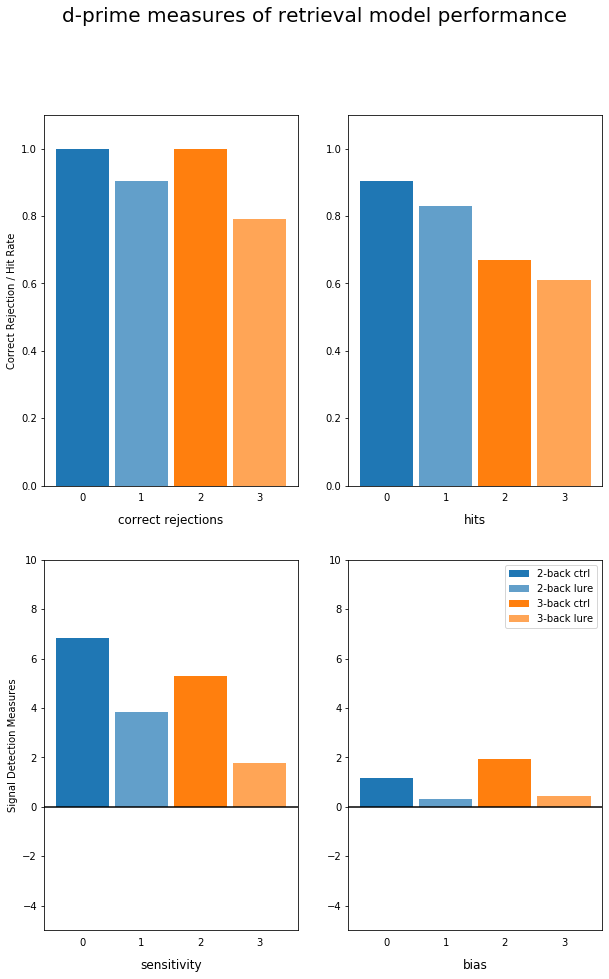

In [67]:
# priority weighting of stimulus similarity (vs context similarity) in EM retrieval
stim_retrieval_weight = 0.4
# hazard rate - likelihood of terminating memory search at each step
h_rate = 0.6
# similarity threshold cutoff - min cosine similarity before search is terminated deterministically
similarity_threshold = 0.5

if task == "nback":
  print("Simulating EM...")
  simulate_em_and_plot_dprimes(ffwm, ctxt_fn, stim_fn,
                               neps_per_task=1000,
                               n_context_steps=n_ctxt_steps,
                               stim_priority_weight=stim_retrieval_weight,
                               hrate = h_rate,
                               sim_thresh = similarity_threshold,
                              figure_path=figure_path)
